In [1]:
%load_ext autoreload
%autoreload

import sys
sys.path.append('..')

import torch
import torch.utils.data as D

import os
import pprint
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

import color.models.predict_color as pred_color_models
import color.data.dataset as color_dataset
import color.training as training
import color.utils.utils as utils

In [2]:
save_dir = '../trained_models/LSTM_627746'
assert os.path.isdir(save_dir)

In [3]:
# Training params and losses
training_params = training.load_training_params(save_dir)
pprint.pprint(training_params)

{'curr_epoch': 1,
 'do_cv': True,
 'draw_plots': False,
 'epoch_cv_losses': [0.049157957060147174,
                     0.048045736498537314,
                     0.0479047403926343,
                     0.049119337470130586,
                     0.05315191133887367,
                     0.04661122887535433,
                     0.04637809348317374,
                     0.04661232180300012,
                     0.04848400470429817,
                     0.04727727333001331,
                     0.04782694841908142,
                     0.04722449209837787,
                     0.049050352214711955,
                     0.04893605055007259,
                     0.04669499608267725,
                     0.04772222991538259,
                     0.04928122157544161,
                     0.04722658511811653,
                     0.051035142577854936,
                     0.04741161903448864],
 'epoch_durations': [23.700257778167725,
                     23.38163161277771,
                  

In [4]:
# Dataset params and partitions
dataset_params, (color_names_train, color_names_cv, color_names_test) = color_dataset.load_dataset_params(save_dir)
pprint.pprint(dataset_params)
print(len(color_names_train), len(color_names_cv), len(color_names_test))

{'batch_size': 1,
 'cv_split': 0.1,
 'dataset': 'big',
 'emb_len': 200,
 'max_words': None,
 'normalize_rgb': True,
 'num_workers': 0,
 'pad_len': None,
 'test_split': 0,
 'use_cuda': True}
16273 1808 0


In [5]:
# Model params and weights
model_weights, model_params = pred_color_models.load_model_params(save_dir)
print(model_params)
print(len(model_weights))

{'name': 'LSTM', 'emb_dim': 200, 'color_dim': 3, 'lr': 0.1, 'momentum': 0.9, 'weight_decay': 0.0001, 'lr_decay': (2, 0.95), 'hidden_dim': 200, 'num_layers': 1, 'dropout': 0}
6


In [9]:
# Load model and pre-trained weights
model = pred_color_models.ColorPredictorLSTM(**model_params)
# model = pred_color_models.ColorPredictorRNN(**model_params)
model.load_state_dict(model_weights)
print(model)
print('Trainable Params:', utils.get_trainable_params(model))

ColorPredictorLSTM(
  (lstm): LSTM(200, 200)
  (linear): Linear(in_features=200, out_features=3, bias=True)
)
Trainable Params: 322203


In [10]:
# Re-create partitions
dataset = color_dataset.Dataset(**dataset_params)
color_name_dict = {color_name: color_rgb for color_rgb, _, color_name in dataset}
print(len(color_name_dict))
train_set = np.array([(name, torch.Tensor.tolist(color_name_dict[name])) for name in color_names_train])
cv_set = np.array([(name, torch.Tensor.tolist(color_name_dict[name])) for name in color_names_cv])
print(train_set[0],len(train_set), len(cv_set))

Loading colors dataset
Loading embeddings
Splitting dataset
18080
['wind chill' list([0.93359375, 0.94921875, 0.9375])] 16273 1808


[[0.6967454552650452, 0.15248747169971466, 0.21914996206760406]]


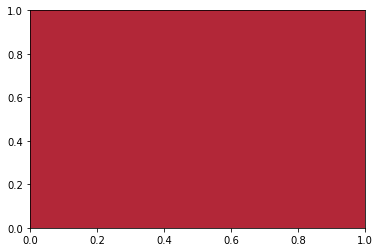

In [11]:
# Runs a new color name throught the model to predict its color
def predict(model, dataset, color_names):
    color_name_embs = [
        torch.tensor(color_dataset.to_embeddings(name, dataset.vocab_dict, dataset.embeddings)).float()
        for name in color_names
    ]
    with torch.no_grad():
        preds = []
        for emb in color_name_embs:
            pred_rgb = model(emb.view(1, emb.shape[0], -1))
            preds.append(torch.Tensor.tolist(pred_rgb.view(-1)))
        return preds
color_preds = predict(model, dataset, ['red'])
print(color_preds)
p = patches.Rectangle((0,0), 5, 5, color=color_preds[0])
fig,ax = plt.subplots(1)
ax.add_patch(p)

In [12]:
def plot_expected_colors(color_names, color_rgb):
    fig = plt.figure(figsize=(15, 2))
    ax = fig.add_subplot(111)
    total_width = 400
    total_height = 200
    col_width = total_width / len(color_names)
    for i, (cn, rgb) in enumerate(zip(color_names, color_rgb)):
        p = patches.Rectangle((col_width*i,0), total_width, total_height, color=rgb)
        ax.add_patch(p)
        ax.text(col_width*(i+0.25),total_height/2, cn)
    plt.xlim([0, total_width])
    plt.ylim([0, total_height])

In [13]:
def pred_and_plot(model, dataset, color_names):
    fig = plt.figure(figsize=(15, 2))
    ax = fig.add_subplot(111)
    total_width = 400
    total_height = 200
    col_width = total_width / len(color_names)
    for i, (cn, pred) in enumerate(zip(color_names, predict(model, dataset, color_names))):
        p = patches.Rectangle((col_width*i,0), total_width, total_height, color=pred)
        ax.add_patch(p)
        ax.text(col_width*(i+0.25),total_height/2, cn)
    plt.xlim([0, total_width])
    plt.ylim([0, total_height])

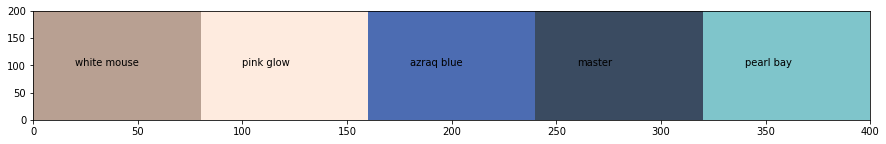

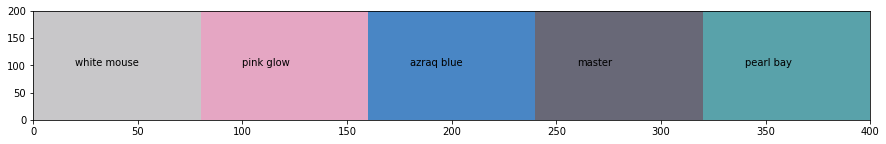

In [14]:
# Plot some training samples
select = 5
idx = np.arange(len(train_set))
np.random.shuffle(idx)
colors_selected = train_set[idx[:select]]
color_names_selected = [color_name for color_name,_ in colors_selected]
color_rgb_selected = [color_rgb for _,color_rgb in colors_selected]
# print(color_names_selected, color_rgb_selected)
plot_expected_colors(color_names_selected, color_rgb_selected)
pred_and_plot(model, dataset, color_names_selected)

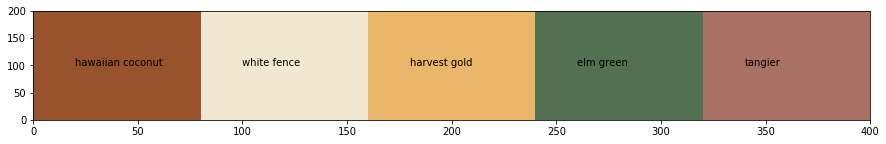

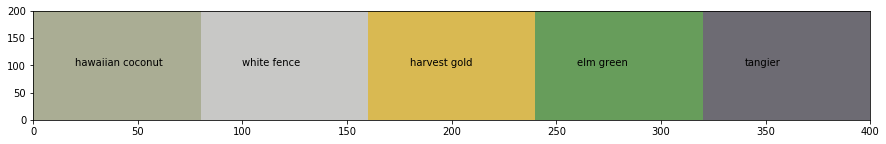

In [15]:
# Plot some CV samples
select = 5
idx = np.arange(len(cv_set))
np.random.shuffle(idx)
colors_selected = cv_set[idx[:select]]
color_names_selected = [color_name for color_name,_ in colors_selected]
color_rgb_selected = [color_rgb for _,color_rgb in colors_selected]
plot_expected_colors(color_names_selected, color_rgb_selected)
pred_and_plot(model, dataset, color_names_selected)

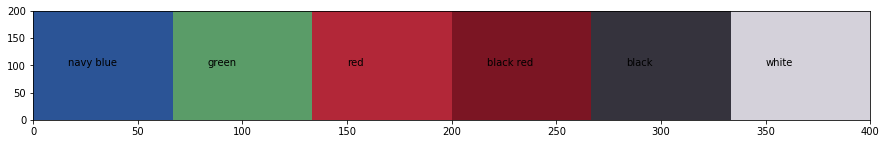

In [16]:
# Plot some more colors
more_color_names = ['navy blue', 'green', 'red', 'black red', 'black', 'white']
pred_and_plot(model, dataset, more_color_names)